# STAT438 Project 2 - Basketball Prediction

## Group 9

**Objective**: Predict game outcomes using FIRST HALF data only

### Prediction Tasks:
1. **Game Winner** - Which team wins the game
2. **Two-Point Trials Leader** - Which team will have more two-point attempts
3. **Turnover Leader** - Which team will have more turnovers

### Algorithms:
- Decision Tree
- XGBoost

### Data:
- Turkish Basketball League (ING BSL)
- Season: 2018-2019

---
## Section 1: Setup and Imports

In [2]:

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# === NEW: PLOTLY IMPORTS ===
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# ===========================

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    cross_validate,
    StratifiedKFold,
    GridSearchCV
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    f1_score,
    precision_score, 
    recall_score,
    roc_auc_score,
    roc_curve,
    make_scorer
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

# Constants
RANDOM_STATE = 42
CV_FOLDS = 5

print("Libraries imported successfully!")
print("Plotly interactive visualizations enabled.")


Libraries imported successfully!
Cross-validation folds: 5
Random state: 42


---
## Section 2: Data Loading and Exploration

In [3]:
# Load the actions data (with encoding for Turkish characters)
actions_df = pd.read_csv('data/actions_3_seasons.csv', encoding='latin-1')

print(f"Actions data shape: {actions_df.shape}")
print(f"\nColumns: {actions_df.columns.tolist()}")

Actions data shape: (462035, 46)

Columns: ['Years', 'actionNumber', 'matchId', 'leagueId', 'clock', 'shotClock', 'timeActual', 'period', 'periodType', 'teamId', 'personId', 'actionType', 'subType', 'qualifiers', 'value', 'previousAction', 'success', 'shirtNumber', 'officialId', 'x', 'y', 'x2', 'y2', 'area', 'side', 'playersTeam1', 'playersTeam2', 'score1', 'score2', 'linkDetail', 'linkDetailLeague', 'linkDetailMatch', 'leagueName', 'matchExternalId', 'teamName', 'teamExternalId', 'linkDetailTeam', 'personExternalId', 'firstName', 'familyName', 'TVName', 'scoreboardName', 'nickName', 'internationalFirstName', 'internationalFamilyName', 'linkDetailPerson']


In [4]:
# Explore the data
print("First 5 rows:")
actions_df.head()

First 5 rows:


,Years,actionNumber,matchId,leagueId,clock,shotClock,timeActual,period,periodType,teamId,personId,actionType,subType,qualifiers,value,previousAction,success,shirtNumber,officialId,x,y,x2,y2,area,side,playersTeam1,playersTeam2,score1,score2,linkDetail,linkDetailLeague,linkDetailMatch,leagueName,matchExternalId,teamName,teamExternalId,linkDetailTeam,personExternalId,firstName,familyName,TVName,scoreboardName,nickName,internationalFirstName,internationalFamilyName,linkDetailPerson
0,2018-2019,1,947443,258,1899-12-31 10:00:00,1899-12-31,2018-10-06 14:30:32,1,REGULAR,NaN,NaN,game,start,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,/v1/basketball/matches/947443/actions/1,/v1/basketball/leagues/258,/v1/basketball/matches/947443,Türkiye Basketbol Federasyonu,1EA2788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-2019,2,947443,258,1899-12-31 10:00:00,1899-12-31,2018-10-06 14:30:32,1,REGULAR,NaN,NaN,period,start,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734448;734446;917343;729310;734447;,729382;960500;960501;729419;729397;,0,0,/v1/basketball/matches/947443/actions/2,/v1/basketball/leagues/258,/v1/basketball/matches/947443,Türkiye Basketbol Federasyonu,1EA2788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-2019,3,947443,258,1899-12-31 10:00:00,1899-12-31,2018-10-06 14:30:32,1,REGULAR,NaN,NaN,clock,start,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734448;734446;917343;729310;734447;,729382;960500;960501;729419;729397;,0,0,/v1/basketball/matches/947443/actions/3,/v1/basketball/leagues/258,/v1/basketball/matches/947443,Türkiye Basketbol Federasyonu,1EA2788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-2019,4,947443,258,1899-12-31 10:00:00,1899-12-31,2018-10-06 14:30:32,1,REGULAR,NaN,NaN,jumpball,startperiod,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734448;734446;917343;729310;734447;,729382;960500;960501;729419;729397;,0,0,/v1/basketball/matches/947443/actions/4,/v1/basketball/leagues/258,/v1/basketball/matches/947443,Türkiye Basketbol Federasyonu,1EA2788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-2019,5,947443,258,1899-12-31 09:58:00,1899-12-31,2018-10-06 14:30:34,1,REGULAR,101345.0,729310.0,jumpball,won,NaN,NaN,4.0,1.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734448;734446;917343;729310;734447;,729382;960500;960501;729419;729397;,0,0,/v1/basketball/matches/947443/actions/5,/v1/basketball/leagues/258,/v1/basketball/matches/947443,Türkiye Basketbol Federasyonu,1EA2788,FENERBAHÇE BEKO,86979.0,/v1/basketball/teams/101345,664904.0,AHMET,DUVERIOGLU,NaN,NaN,NaN,AHMET,DUVERIOGLU,/v1/basketball/persons/729310


In [5]:
# Check seasons available
print("Seasons in data:")
print(actions_df['Years'].value_counts())

Seasons in data:
Years
2020-2021    180161
2018-2019    155134
2019-2020    126740
Name: count, dtype: int64


In [6]:
# Check action types
print("Action Types Distribution:")
print(actions_df['actionType'].value_counts())

Action Types Distribution:
actionType
clock           120368
substitution     65271
2pt              51881
rebound          47004
3pt              33206
assist           26148
foul             26034
foulon           25274
freethrow        23475
turnover         16906
steal             8703
timeout           5673
period            5461
block             2977
jumpball          2305
game              1349
Name: count, dtype: int64


In [7]:
# Check periods
print("Period Distribution:")
print(actions_df['period'].value_counts().sort_index())

Period Distribution:
period
1    106621
2    120215
3    112614
4    122585
Name: count, dtype: int64


In [8]:
# Count matches per season
print("Matches per Season:")
for season in actions_df['Years'].unique():
    n_matches = actions_df[actions_df['Years'] == season]['matchId'].nunique()
    print(f"  {season}: {n_matches} matches")

Matches per Season:
  2018-2019: 233 matches
  2019-2020: 183 matches
  2020-2021: 259 matches


In [9]:
# Select ONE season for prediction (2018-2019 has the most matches)
SELECTED_SEASON = '2018-2019'
actions_season = actions_df[actions_df['Years'] == SELECTED_SEASON].copy()

print(f"Selected Season: {SELECTED_SEASON}")
print(f"Number of actions: {len(actions_season):,}")
print(f"Number of matches: {actions_season['matchId'].nunique()}")

Selected Season: 2018-2019
Number of actions: 155,134
Number of matches: 233


---
## Section 3: Data Preprocessing and Feature Engineering

In [10]:
# Filter first half data (periods 1 and 2)
first_half_df = actions_season[actions_season['period'].isin([1, 2])].copy()

print(f"First half actions: {len(first_half_df):,}")
print(f"Percentage of total: {len(first_half_df)/len(actions_season)*100:.1f}%")

First half actions: 76,491
Percentage of total: 49.3%


In [11]:
# Get unique matches
match_ids = actions_season['matchId'].unique()
print(f"Total matches to process: {len(match_ids)}")

Total matches to process: 233


In [12]:
# Function to identify teams per match
def get_match_teams(match_id, data):
    """
    Extract the two teams playing in a match.
    Returns (team1_id, team2_id) or (None, None) if not found.
    """
    match_data = data[data['matchId'] == match_id]
    teams = match_data[match_data['teamId'].notna()]['teamId'].unique()
    
    if len(teams) >= 2:
        return int(teams[0]), int(teams[1])
    return None, None

# Build team mapping for all matches
match_teams = {}
for match_id in match_ids:
    team1, team2 = get_match_teams(match_id, actions_season)
    if team1 and team2:
        match_teams[match_id] = {'team1': team1, 'team2': team2}

print(f"Matches with valid teams: {len(match_teams)}")

Matches with valid teams: 233


In [13]:
def extract_first_half_features(match_id, first_half_data, full_data, match_teams_dict):
    """
    Extract features from first half data for a single match.
    Including ADVANCED features: Paint Dominance, Lead Share, Scoring Runs, Defensive Pressure.
    """
    if match_id not in match_teams_dict:
        return None
    
    team1 = match_teams_dict[match_id]['team1']
    team2 = match_teams_dict[match_id]['team2']
    
    # First half data for this match, sorted by action sequence
    match_1h = first_half_data[first_half_data['matchId'] == match_id].sort_values('actionNumber')
    
    # Team-specific first half data
    team1_1h = match_1h[match_1h['teamId'] == team1]
    team2_1h = match_1h[match_1h['teamId'] == team2]
    
    features = {'matchId': match_id, 'team1_id': team1, 'team2_id': team2}
    
    # Helper to avoid division by zero
    def safe_div(a, b):
        return a / b if b > 0 else 0
    
    # === RAW FIRST HALF FEATURES ===
    
    # 1. Two-Point Attempts & Made
    features['team1_2pt_attempts_1h'] = len(team1_1h[team1_1h['actionType'] == '2pt'])
    features['team2_2pt_attempts_1h'] = len(team2_1h[team2_1h['actionType'] == '2pt'])
    features['team1_2pt_made_1h'] = len(team1_1h[(team1_1h['actionType'] == '2pt') & (team1_1h['success'] == 1)])
    features['team2_2pt_made_1h'] = len(team2_1h[(team2_1h['actionType'] == '2pt') & (team2_1h['success'] == 1)])
    
    # 2. Three-Point Attempts & Made
    features['team1_3pt_attempts_1h'] = len(team1_1h[team1_1h['actionType'] == '3pt'])
    features['team2_3pt_attempts_1h'] = len(team2_1h[team2_1h['actionType'] == '3pt'])
    features['team1_3pt_made_1h'] = len(team1_1h[(team1_1h['actionType'] == '3pt') & (team1_1h['success'] == 1)])
    features['team2_3pt_made_1h'] = len(team2_1h[(team2_1h['actionType'] == '3pt') & (team2_1h['success'] == 1)])
    
    # 3. Turnovers
    features['team1_turnovers_1h'] = len(team1_1h[team1_1h['actionType'] == 'turnover'])
    features['team2_turnovers_1h'] = len(team2_1h[team2_1h['actionType'] == 'turnover'])
    
    # 4. Rebounds (Split into Offensive and Defensive)
    team1_rebounds = team1_1h[team1_1h['actionType'] == 'rebound']
    team2_rebounds = team2_1h[team2_1h['actionType'] == 'rebound']
    
    features['team1_orb_1h'] = len(team1_rebounds[team1_rebounds['subType'] == 'offensive'])
    features['team1_drb_1h'] = len(team1_rebounds[team1_rebounds['subType'] == 'defensive'])
    features['team2_orb_1h'] = len(team2_rebounds[team2_rebounds['subType'] == 'offensive'])
    features['team2_drb_1h'] = len(team2_rebounds[team2_rebounds['subType'] == 'defensive'])
    
    features['team1_rebounds_1h'] = len(team1_rebounds)
    features['team2_rebounds_1h'] = len(team2_rebounds)
    
    # 5. Assists
    features['team1_assists_1h'] = len(team1_1h[team1_1h['actionType'] == 'assist'])
    features['team2_assists_1h'] = len(team2_1h[team2_1h['actionType'] == 'assist'])
    
    # 6. Steals
    features['team1_steals_1h'] = len(team1_1h[team1_1h['actionType'] == 'steal'])
    features['team2_steals_1h'] = len(team2_1h[team2_1h['actionType'] == 'steal'])
    
    # 7. Blocks
    features['team1_blocks_1h'] = len(team1_1h[team1_1h['actionType'] == 'block'])
    features['team2_blocks_1h'] = len(team2_1h[team2_1h['actionType'] == 'block'])
    
    # 8. Fouls & Foul Trouble
    team1_fouls = team1_1h[team1_1h['actionType'] == 'foul']
    team2_fouls = team2_1h[team2_1h['actionType'] == 'foul']
    features['team1_fouls_1h'] = len(team1_fouls)
    features['team2_fouls_1h'] = len(team2_fouls)
    
    # Count players with >= 3 fouls
    if len(team1_fouls) > 0:
        t1_foul_counts = team1_fouls['personId'].value_counts()
        features['team1_foul_trouble_count'] = len(t1_foul_counts[t1_foul_counts >= 3])
    else:
        features['team1_foul_trouble_count'] = 0
        
    if len(team2_fouls) > 0:
        t2_foul_counts = team2_fouls['personId'].value_counts()
        features['team2_foul_trouble_count'] = len(t2_foul_counts[t2_foul_counts >= 3])
    else:
        features['team2_foul_trouble_count'] = 0
    
    # 9. Free Throws
    features['team1_freethrows_attempts_1h'] = len(team1_1h[team1_1h['actionType'] == 'freethrow'])
    features['team2_freethrows_attempts_1h'] = len(team2_1h[team2_1h['actionType'] == 'freethrow'])
    features['team1_freethrows_1h'] = len(team1_1h[(team1_1h['actionType'] == 'freethrow') & (team1_1h['success'] == 1)])
    features['team2_freethrows_1h'] = len(team2_1h[(team2_1h['actionType'] == 'freethrow') & (team2_1h['success'] == 1)])
    
    # 10. First Half Scores
    period2_data = match_1h[match_1h['period'] == 2].sort_values('actionNumber')
    if len(period2_data) > 0:
        last_action = period2_data.iloc[-1]
        features['team1_score_1h'] = last_action['score1'] if pd.notna(last_action['score1']) else 0
        features['team2_score_1h'] = last_action['score2'] if pd.notna(last_action['score2']) else 0
    else:
        period1_data = match_1h[match_1h['period'] == 1].sort_values('actionNumber')
        if len(period1_data) > 0:
            last_action = period1_data.iloc[-1]
            features['team1_score_1h'] = last_action['score1'] if pd.notna(last_action['score1']) else 0
            features['team2_score_1h'] = last_action['score2'] if pd.notna(last_action['score2']) else 0
        else:
            features['team1_score_1h'] = 0
            features['team2_score_1h'] = 0

    # === NEW: SPATIAL FEATURES (Paint Dominance) ===
    paint_areas = ['inthepaint', 'underbasket']
    t1_paint_made = len(team1_1h[(team1_1h['area'].isin(paint_areas)) & (team1_1h['success'] == 1)])
    t2_paint_made = len(team2_1h[(team2_1h['area'].isin(paint_areas)) & (team2_1h['success'] == 1)])
    
    # Points in Paint (approx 2 pts each)
    features['team1_paint_points'] = t1_paint_made * 2 
    features['team2_paint_points'] = t2_paint_made * 2
    features['team1_paint_dominance'] = safe_div(features['team1_paint_points'], features['team1_score_1h'])
    features['team2_paint_dominance'] = safe_div(features['team2_paint_points'], features['team2_score_1h'])
    features['paint_dominance_diff'] = features['team1_paint_dominance'] - features['team2_paint_dominance']

    # === NEW: TEMPORAL FEATURES (Lead Share & Runs) ===
    # Lead Share
    lead_actions_t1 = len(match_1h[match_1h['score1'] > match_1h['score2']])
    lead_actions_t2 = len(match_1h[match_1h['score2'] > match_1h['score1']])
    total_actions = len(match_1h) if len(match_1h) > 0 else 1
    
    features['team1_lead_share'] = safe_div(lead_actions_t1, total_actions)
    features['team2_lead_share'] = safe_div(lead_actions_t2, total_actions)
    features['lead_share_diff'] = features['team1_lead_share'] - features['team2_lead_share']
    
    # Max Scoring Run (Consecutive scoring events)
    scorers = match_1h[match_1h['success'] == 1]['teamId']
    max_run_t1 = 0
    max_run_t2 = 0
    if len(scorers) > 0:
        grps = scorers.groupby((scorers != scorers.shift()).cumsum())
        for _, grp in grps:
            team = grp.iloc[0]
            run_len = len(grp)
            if team == team1:
                max_run_t1 = max(max_run_t1, run_len)
            elif team == team2:
                max_run_t2 = max(max_run_t2, run_len)
    
    features['team1_max_run'] = max_run_t1
    features['team2_max_run'] = max_run_t2
    features['max_run_diff'] = features['team1_max_run'] - features['team2_max_run']

    # === ADVANCED METRICS (Four Factors & Efficiency) ===

    # Total Field Goal Attempts
    features['team1_fga'] = features['team1_2pt_attempts_1h'] + features['team1_3pt_attempts_1h']
    features['team2_fga'] = features['team2_2pt_attempts_1h'] + features['team2_3pt_attempts_1h']
    
    # Total Field Goals Made
    features['team1_fgm'] = features['team1_2pt_made_1h'] + features['team1_3pt_made_1h']
    features['team2_fgm'] = features['team2_2pt_made_1h'] + features['team2_3pt_made_1h']

    # 1. Possessions (Approximate)
    # Formula: FGA + 0.44 * FTA + TOV - ORB
    features['team1_possessions'] = features['team1_fga'] + 0.44 * features['team1_freethrows_attempts_1h'] + features['team1_turnovers_1h'] - features['team1_orb_1h']
    features['team2_possessions'] = features['team2_fga'] + 0.44 * features['team2_freethrows_attempts_1h'] + features['team2_turnovers_1h'] - features['team2_orb_1h']
    
    # === NEW: DEFENSIVE PRESSURE ===
    features['team1_def_pressure'] = safe_div(features['team1_steals_1h'] + features['team1_blocks_1h'] + features['team2_turnovers_1h'], features['team2_possessions'])
    features['team2_def_pressure'] = safe_div(features['team2_steals_1h'] + features['team2_blocks_1h'] + features['team1_turnovers_1h'], features['team1_possessions'])
    features['def_pressure_diff'] = features['team1_def_pressure'] - features['team2_def_pressure']

    # 2. Effective Field Goal Percentage (eFG%)
    # Formula: (FGM + 0.5 * 3PM) / FGA
    features['team1_efg_pct'] = safe_div(features['team1_fgm'] + 0.5 * features['team1_3pt_made_1h'], features['team1_fga'])
    features['team2_efg_pct'] = safe_div(features['team2_fgm'] + 0.5 * features['team2_3pt_made_1h'], features['team2_fga'])
    features['efg_pct_diff'] = features['team1_efg_pct'] - features['team2_efg_pct']
    
    # 3. Turnover Percentage (TOV%)
    # Formula: TOV / Possessions
    features['team1_tov_pct'] = safe_div(features['team1_turnovers_1h'], features['team1_possessions'])
    features['team2_tov_pct'] = safe_div(features['team2_turnovers_1h'], features['team2_possessions'])
    features['tov_pct_diff'] = features['team1_tov_pct'] - features['team2_tov_pct']
    
    # 4. Offensive Rebound Percentage (ORB%)
    # Formula: ORB / (ORB + Opponent DRB)
    features['team1_orb_pct'] = safe_div(features['team1_orb_1h'], features['team1_orb_1h'] + features['team2_drb_1h'])
    features['team2_orb_pct'] = safe_div(features['team2_orb_1h'], features['team2_orb_1h'] + features['team1_drb_1h'])
    features['orb_pct_diff'] = features['team1_orb_pct'] - features['team2_orb_pct']
    
    # 5. Free Throw Rate (FTR)
    # Formula: FTA / FGA
    features['team1_ftr'] = safe_div(features['team1_freethrows_attempts_1h'], features['team1_fga'])
    features['team2_ftr'] = safe_div(features['team2_freethrows_attempts_1h'], features['team2_fga'])
    features['ftr_diff'] = features['team1_ftr'] - features['team2_ftr']

    # 6. True Shooting Percentage (TS%)
    # Formula: Points / (2 * (FGA + 0.44 * FTA))
    features['team1_ts_pct'] = safe_div(features['team1_score_1h'], 2 * (features['team1_fga'] + 0.44 * features['team1_freethrows_attempts_1h']))
    features['team2_ts_pct'] = safe_div(features['team2_score_1h'], 2 * (features['team2_fga'] + 0.44 * features['team2_freethrows_attempts_1h']))
    features['ts_pct_diff'] = features['team1_ts_pct'] - features['team2_ts_pct']

    # 7. Offensive Rating (Points per 100 Possessions)
    features['team1_off_rating'] = safe_div(features['team1_score_1h'], features['team1_possessions']) * 100
    features['team2_off_rating'] = safe_div(features['team2_score_1h'], features['team2_possessions']) * 100
    features['off_rating_diff'] = features['team1_off_rating'] - features['team2_off_rating']
    
    # === LEGACY / SIMPLE DERIVED FEATURES ===
    features['total_shots_1h_team1'] = features['team1_fga']
    features['total_shots_1h_team2'] = features['team2_fga']
    features['score_diff_1h'] = features['team1_score_1h'] - features['team2_score_1h']
    features['2pt_diff_1h'] = features['team1_2pt_made_1h'] - features['team2_2pt_made_1h']
    features['turnover_diff_1h'] = features['team1_turnovers_1h'] - features['team2_turnovers_1h']
    features['rebound_diff_1h'] = features['team1_rebounds_1h'] - features['team2_rebounds_1h']
    features['assist_diff_1h'] = features['team1_assists_1h'] - features['team2_assists_1h']
    
    features['team1_ast_to_ratio'] = safe_div(features['team1_assists_1h'], features['team1_turnovers_1h'])
    features['team2_ast_to_ratio'] = safe_div(features['team2_assists_1h'], features['team2_turnovers_1h'])
    features['ast_to_ratio_diff'] = features['team1_ast_to_ratio'] - features['team2_ast_to_ratio']
    
    return features


In [14]:
# === PHASE 3: ROLLING FEATURES (Team Form) ===
# We must process matches chronologically to calculate "pre-match" form.

# 1. Sort matches by date
matches_with_date = []
for match_id in match_teams.keys():
    # Get Time for this match
    match_data = actions_season[actions_season['matchId'] == match_id]
    if len(match_data) > 0 and 'timeActual' in match_data.columns:
        # Use first available time
        match_time = match_data['timeActual'].iloc[0] 
        matches_with_date.append({'matchId': match_id, 'time': match_time})

# Sort
matches_sorted = sorted(matches_with_date, key=lambda x: str(x['time']))
sorted_match_ids = [m['matchId'] for m in matches_sorted]

print(f"Sorted {len(sorted_match_ids)} matches chronologically.")

# 2. Initialize Team History
team_history = {} # {teamId: {'wins': [], 'scores': [], 'def_scores': [], ...}}

def get_last_n_avg(history_list, n=5):
    if not history_list: return 0
    return np.mean(history_list[-n:])

def get_winning_streak(pro_history):
    streak = 0
    for result in reversed(pro_history):
        if result == 1: streak += 1
        else: break
    return streak

# 3. Main Extraction Loop with History Update
all_features = []

print("Extracting features with Historical Context...")

for i, match_id in enumerate(sorted_match_ids):
    # Standard Features
    features = extract_first_half_features(match_id, first_half_df, actions_season, match_teams)
    if not features: continue
        
    t1 = features['team1_id']
    t2 = features['team2_id']
    
    # Initialize history if new team
    if t1 not in team_history: team_history[t1] = {'wins': [], 'scores': [], 'conceded': []}
    if t2 not in team_history: team_history[t2] = {'wins': [], 'scores': [], 'conceded': []}
    
    # --- EXTRACT PRE-MATCH FORM (Before updating with current game) ---
    
    # Win Rates
    features['team1_season_win_rate'] = np.mean(team_history[t1]['wins']) if team_history[t1]['wins'] else 0.5
    features['team2_season_win_rate'] = np.mean(team_history[t2]['wins']) if team_history[t2]['wins'] else 0.5
    features['team1_last5_win_rate'] = get_last_n_avg(team_history[t1]['wins'], 5)
    features['team2_last5_win_rate'] = get_last_n_avg(team_history[t2]['wins'], 5)
    
    # Streaks
    features['team1_win_streak'] = get_winning_streak(team_history[t1]['wins'])
    features['team2_win_streak'] = get_winning_streak(team_history[t2]['wins'])
    
    # Scoring Form (Avg First Half Score)
    features['team1_avg_score_season'] = np.mean(team_history[t1]['scores']) if team_history[t1]['scores'] else 0
    features['team2_avg_score_season'] = np.mean(team_history[t2]['scores']) if team_history[t2]['scores'] else 0
    features['team1_avg_score_last5'] = get_last_n_avg(team_history[t1]['scores'], 5)
    features['team2_avg_score_last5'] = get_last_n_avg(team_history[t2]['scores'], 5)
    
    # Defensive Form (Avg Points Conceded)
    features['team1_avg_conceded_season'] = np.mean(team_history[t1]['conceded']) if team_history[t1]['conceded'] else 0
    features['team2_avg_conceded_season'] = np.mean(team_history[t2]['conceded']) if team_history[t2]['conceded'] else 0
    
    # Differentials
    features['season_win_rate_diff'] = features['team1_season_win_rate'] - features['team2_season_win_rate']
    features['last5_win_rate_diff'] = features['team1_last5_win_rate'] - features['team2_last5_win_rate']
    features['win_streak_diff'] = features['team1_win_streak'] - features['team2_win_streak']
    
    all_features.append(features)
    
    # --- UPDATE HISTORY (For next games) ---
    # We need the ACTUAL result of this game to update history.
    # We can get it from 'actions_season' or recalculate quickly.
    # Let's use the helper we already have logic for in 'get_game_outcomes' 
    # BUT 'get_game_outcomes' is defined LATER in the notebook. 
    # We must inline a simple winner check here for efficiency/correctness.
    
    match_full = actions_season[actions_season['matchId'] == match_id]
    # Simple score check (max score in periods) - reusing robust logic approx
    # Actually, let's just use the score columns in the actions? 
    # Safe way:
    f_score1 = 0
    f_score2 = 0
    # Try find game end
    game_end = match_full[(match_full['actionType'] == 'game') & (match_full['subType'] == 'end')]
    if len(game_end) > 0:
        f_score1 = game_end.iloc[0]['score1']
        f_score2 = game_end.iloc[0]['score2']
    else:
        # Last action
        last = match_full.iloc[-1]
        f_score1 = last['score1']
        f_score2 = last['score2']
        if pd.isna(f_score1): f_score1 = 0
        if pd.isna(f_score2): f_score2 = 0
        
    t1_won = 1 if f_score1 > f_score2 else 0
    t2_won = 1 if f_score2 > f_score1 else 0 # ignores draw logic which is rare/impossible in basketball usually
    
    team_history[t1]['wins'].append(t1_won)
    team_history[t2]['wins'].append(t2_won)
    
    # Update scores (First Half scores are already in 'features')
    team_history[t1]['scores'].append(features['team1_score_1h'])
    team_history[t2]['scores'].append(features['team2_score_1h'])
    team_history[t1]['conceded'].append(features['team2_score_1h'])
    team_history[t2]['conceded'].append(features['team1_score_1h'])
    
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(sorted_match_ids)} matches")

features_df = pd.DataFrame(all_features)
print(f"\nFeatures extracted: {len(features_df)}")


Extracting first half features...
  Processed 50/233 matches
  Processed 100/233 matches
  Processed 150/233 matches
  Processed 200/233 matches

Features extracted for 233 matches

Feature columns: ['matchId', 'team1_id', 'team2_id', 'team1_2pt_attempts_1h', 'team2_2pt_attempts_1h', 'team1_3pt_attempts_1h', 'team2_3pt_attempts_1h', 'team1_turnovers_1h', 'team2_turnovers_1h', 'team1_rebounds_1h', 'team2_rebounds_1h', 'team1_assists_1h', 'team2_assists_1h', 'team1_steals_1h', 'team2_steals_1h', 'team1_blocks_1h', 'team2_blocks_1h', 'team1_fouls_1h', 'team2_fouls_1h', 'team1_freethrows_1h', 'team2_freethrows_1h', 'team1_score_1h', 'team2_score_1h', 'total_shots_1h_team1', 'total_shots_1h_team2', 'score_diff_1h', '2pt_diff_1h', 'turnover_diff_1h', 'rebound_diff_1h', 'assist_diff_1h', 'team1_shooting_efficiency', 'team2_shooting_efficiency', 'shooting_efficiency_diff', 'team1_ast_to_ratio', 'team2_ast_to_ratio', 'ast_to_ratio_diff']


In [15]:
# Preview the features
features_df.head()

,matchId,team1_id,team2_id,team1_2pt_attempts_1h,team2_2pt_attempts_1h,team1_3pt_attempts_1h,team2_3pt_attempts_1h,team1_turnovers_1h,team2_turnovers_1h,team1_rebounds_1h,team2_rebounds_1h,team1_assists_1h,team2_assists_1h,team1_steals_1h,team2_steals_1h,team1_blocks_1h,team2_blocks_1h,team1_fouls_1h,team2_fouls_1h,team1_freethrows_1h,team2_freethrows_1h,team1_score_1h,team2_score_1h,total_shots_1h_team1,total_shots_1h_team2,score_diff_1h,2pt_diff_1h,turnover_diff_1h,rebound_diff_1h,assist_diff_1h,team1_shooting_efficiency,team2_shooting_efficiency,shooting_efficiency_diff,team1_ast_to_ratio,team2_ast_to_ratio,ast_to_ratio_diff
0,947443,101345,101343,17,18,9,5,7,8,16,8,7,8,5,2,1,2,11,10,9,8,38,35,26,23,3,-1,-1,8,-1,1.461538,1.521739,-0.060201,0.875000,0.888889,-0.013889
1,947445,101353,101350,11,22,16,11,10,7,20,22,5,6,1,5,3,1,7,12,8,6,28,26,27,33,2,-11,3,-2,-1,1.037037,0.787879,0.249158,0.454545,0.750000,-0.295455
2,947558,101340,101342,21,22,14,11,4,9,17,23,8,7,8,3,1,1,8,7,7,6,37,40,35,33,-3,-1,-5,-6,1,1.057143,1.212121,-0.154978,1.600000,0.700000,0.900000
3,947559,101344,101347,17,22,13,12,7,1,24,17,4,7,1,3,1,0,9,11,8,6,31,31,30,34,0,-5,6,7,-3,1.033333,0.911765,0.121569,0.500000,3.500000,-3.000000
4,947560,101339,101346,29,23,9,9,4,8,26,22,8,3,3,3,1,3,9,9,7,11,28,32,38,32,-4,6,-4,4,5,0.736842,1.000000,-0.263158,1.600000,0.333333,1.266667


In [16]:
# Summary statistics
features_df.describe()

,matchId,team1_id,team2_id,team1_2pt_attempts_1h,team2_2pt_attempts_1h,team1_3pt_attempts_1h,team2_3pt_attempts_1h,team1_turnovers_1h,team2_turnovers_1h,team1_rebounds_1h,team2_rebounds_1h,team1_assists_1h,team2_assists_1h,team1_steals_1h,team2_steals_1h,team1_blocks_1h,team2_blocks_1h,team1_fouls_1h,team2_fouls_1h,team1_freethrows_1h,team2_freethrows_1h,team1_score_1h,team2_score_1h,total_shots_1h_team1,total_shots_1h_team2,score_diff_1h,2pt_diff_1h,turnover_diff_1h,rebound_diff_1h,assist_diff_1h,team1_shooting_efficiency,team2_shooting_efficiency,shooting_efficiency_diff,team1_ast_to_ratio,team2_ast_to_ratio,ast_to_ratio_diff
count,2.330000e+02,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000,233.000000
mean,9.917020e+05,101344.789700,101345.261803,20.000000,20.012876,11.849785,12.240343,6.077253,5.875536,17.716738,17.484979,9.785408,9.416309,3.038627,3.253219,1.107296,0.922747,8.965665,8.918455,7.579399,7.467811,39.618026,38.519313,31.849785,32.253219,1.098712,-0.012876,0.201717,0.231760,0.369099,1.265252,1.212539,0.052713,1.663681,1.622459,0.041222
std,7.072526e+04,4.320508,4.525326,4.388465,4.430965,3.530497,3.069975,2.628269,2.468238,4.290780,4.575138,3.008086,3.309220,1.786748,1.934331,1.114786,0.961790,2.420926,2.459544,4.139164,4.153316,8.733853,8.914383,4.592790,4.613539,10.890665,5.507425,3.561963,6.087538,4.618300,0.304266,0.292193,0.411346,1.189139,1.099962,1.723450
min,9.474430e+05,101338.000000,101338.000000,8.000000,8.000000,4.000000,4.000000,0.000000,0.000000,5.000000,6.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,19.000000,19.000000,19.000000,20.000000,-37.000000,-14.000000,-12.000000,-22.000000,-15.000000,0.575758,0.608696,-1.365591,0.384615,0.142857,-10.571429
25%,9.724440e+05,101341.000000,101341.000000,17.000000,17.000000,9.000000,10.000000,4.000000,4.000000,15.000000,15.000000,8.000000,7.000000,2.000000,2.000000,0.000000,0.000000,7.000000,7.000000,5.000000,5.000000,35.000000,33.000000,29.000000,29.000000,-6.000000,-4.000000,-2.000000,-3.000000,-2.000000,1.062500,1.000000,-0.252679,1.000000,1.000000,-0.722222
50%,9.725100e+05,101345.000000,101345.000000,20.000000,19.000000,12.000000,12.000000,6.000000,6.000000,17.000000,17.000000,10.000000,9.000000,3.000000,3.000000,1.000000,1.000000,9.000000,9.000000,7.000000,7.000000,39.000000,38.000000,31.000000,32.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,1.266667,1.175000,0.065978,1.428571,1.375000,-0.029412
75%,9.725770e+05,101349.000000,101349.000000,23.000000,23.000000,14.000000,14.000000,7.000000,7.000000,21.000000,21.000000,12.000000,11.000000,4.000000,4.000000,2.000000,1.000000,10.000000,10.000000,9.000000,10.000000,45.000000,43.000000,34.000000,35.000000,8.000000,4.000000,3.000000,3.000000,4.000000,1.440000,1.405405,0.311111,2.000000,2.200000,0.685714
max,1.289763e+06,101353.000000,101353.000000,33.000000,33.000000,24.000000,21.000000,16.000000,14.000000,29.000000,37.000000,18.000000,20.000000,10.000000,10.000000,6.000000,5.000000,16.000000,17.000000,22.000000,24.000000,103.000000,106.000000,47.000000,50.000000,36.000000,14.000000,11.000000,16.000000,13.000000,2.368421,2.120000,1.729532,13.000000,12.000000,12.000000


### Custom Metrics Created for This Project

We created **3 custom metrics** to capture different aspects of basketball performance:

#### 1. Paint Dominance (Spatial Scoring Efficiency)
**Formula:** `paint_points / total_first_half_score`

**Rationale:** Measures what percentage of a team's scoring comes from high-percentage shots in the paint area (close to basket). Teams with higher paint dominance typically have better interior offense and are more efficient at scoring.

**Features:**
- `team1_paint_dominance`: Team 1 paint scoring percentage
- `team2_paint_dominance`: Team 2 paint scoring percentage
- `paint_dominance_diff`: Difference between teams

---

#### 2. Defensive Pressure (Defensive Effectiveness)
**Formula:** `(steals + blocks + opponent_turnovers) / opponent_possessions`

**Rationale:** Quantifies how effectively a team pressures opponents, forcing turnovers and disrupting plays. Higher values indicate aggressive, effective defense that creates transition opportunities.

**Features:**
- `team1_def_pressure`: Team 1 defensive pressure rate
- `team2_def_pressure`: Team 2 defensive pressure rate
- `def_pressure_diff`: Difference between teams

---

#### 3. Lead Share & Max Scoring Run (Momentum)
**Formula:**
- Lead Share: `actions_with_lead / total_actions`
- Max Run: Longest consecutive scoring streak

**Rationale:** Captures game momentum and control. Teams that lead for longer periods and have longer scoring runs typically have better game management and psychological advantage.

**Features:**
- `team1_lead_share`: Percentage of game Team 1 had the lead
- `team2_lead_share`: Percentage of game Team 2 had the lead
- `lead_share_diff`: Difference in lead control
- `team1_max_run`, `team2_max_run`: Longest scoring streaks
- `max_run_diff`: Difference in momentum

---

**These custom metrics provide insights beyond traditional box score statistics, capturing spatial efficiency (paint), defensive intensity, and game flow/momentum.**


---
## Section 4: Target Variable Creation

In [17]:
def get_game_outcomes(match_id, full_data, match_teams_dict):
    """
    Get final game outcomes from FULL GAME data.
    
    Returns:
    - Dictionary with winner, 2pt_leader, turnover_leader
    """
    if match_id not in match_teams_dict:
        return None
    
    team1 = match_teams_dict[match_id]['team1']
    team2 = match_teams_dict[match_id]['team2']
    
    match_data = full_data[full_data['matchId'] == match_id]
    
    # === FINAL SCORE (Game Winner) ===
    # Try to get game end action
    game_end = match_data[(match_data['actionType'] == 'game') & 
                          (match_data['subType'] == 'end')]
    
    if len(game_end) > 0:
        final_score1 = game_end.iloc[0]['score1']
        final_score2 = game_end.iloc[0]['score2']
    else:
        # Fallback: last action in period 4
        p4_data = match_data[match_data['period'] == 4].sort_values('actionNumber')
        if len(p4_data) > 0:
            final_score1 = p4_data.iloc[-1]['score1']
            final_score2 = p4_data.iloc[-1]['score2']
        else:
            # Last resort: last action in any period
            last_action = match_data.sort_values('actionNumber').iloc[-1]
            final_score1 = last_action['score1']
            final_score2 = last_action['score2']
    
    # Handle NaN scores
    final_score1 = final_score1 if pd.notna(final_score1) else 0
    final_score2 = final_score2 if pd.notna(final_score2) else 0
    
    # Winner: 1 = team1 wins, 0 = team2 wins
    winner = 1 if final_score1 > final_score2 else 0
    
    # === FULL GAME STATISTICS ===
    team1_data = match_data[match_data['teamId'] == team1]
    team2_data = match_data[match_data['teamId'] == team2]
    
    # Two-Point Attempts (full game)
    team1_2pt_total = len(team1_data[team1_data['actionType'] == '2pt'])
    team2_2pt_total = len(team2_data[team2_data['actionType'] == '2pt'])
    twopoint_leader = 1 if team1_2pt_total >= team2_2pt_total else 0
    
    # Turnovers (full game)
    team1_to_total = len(team1_data[team1_data['actionType'] == 'turnover'])
    team2_to_total = len(team2_data[team2_data['actionType'] == 'turnover'])
    turnover_leader = 1 if team1_to_total >= team2_to_total else 0
    
    return {
        'matchId': match_id,
        'final_score1': final_score1,
        'final_score2': final_score2,
        'team1_2pt_total': team1_2pt_total,
        'team2_2pt_total': team2_2pt_total,
        'team1_to_total': team1_to_total,
        'team2_to_total': team2_to_total,
        'winner': winner,
        'twopoint_leader': twopoint_leader,
        'turnover_leader': turnover_leader
    }

In [18]:
# Extract outcomes for all matches
print("Extracting game outcomes...")

outcomes = []
for match_id in features_df['matchId'].unique():
    outcome = get_game_outcomes(match_id, actions_season, match_teams)
    if outcome:
        outcomes.append(outcome)

outcomes_df = pd.DataFrame(outcomes)
print(f"Outcomes extracted for {len(outcomes_df)} matches")

Extracting game outcomes...
Outcomes extracted for 233 matches


In [19]:
# Merge features with targets
final_df = features_df.merge(outcomes_df, on='matchId')
print(f"Final dataset shape: {final_df.shape}")

print("\n=== Target Variable Distribution ===")
print(f"\nGame Winner (Team1 wins): {final_df['winner'].sum()} / {len(final_df)} ({final_df['winner'].mean()*100:.1f}%)")
print(f"2PT Leader (Team1 leads): {final_df['twopoint_leader'].sum()} / {len(final_df)} ({final_df['twopoint_leader'].mean()*100:.1f}%)")
print(f"Turnover Leader (Team1): {final_df['turnover_leader'].sum()} / {len(final_df)} ({final_df['turnover_leader'].mean()*100:.1f}%)")

Final dataset shape: (233, 45)

=== Target Variable Distribution ===

Game Winner (Team1 wins): 145 / 233 (62.2%)
2PT Leader (Team1 leads): 130 / 233 (55.8%)
Turnover Leader (Team1): 127 / 233 (54.5%)


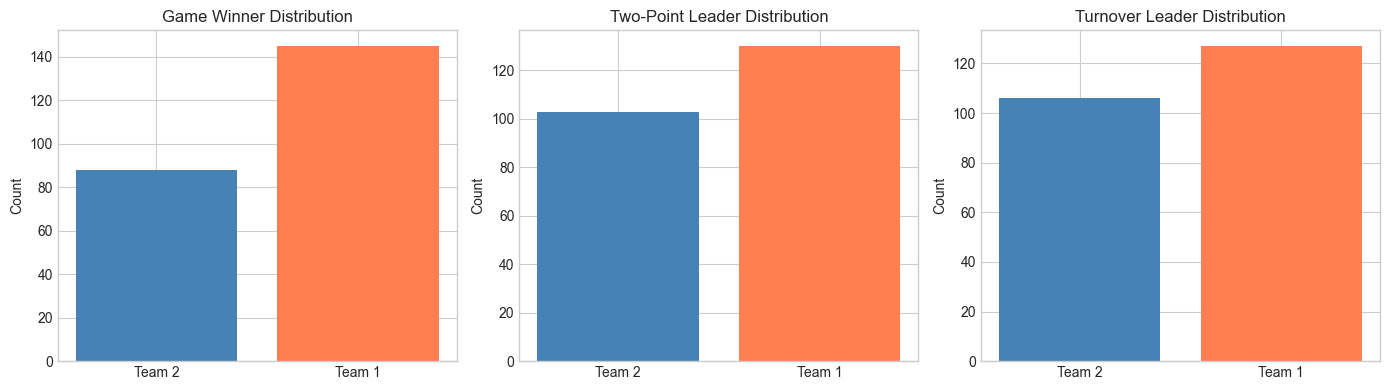

In [20]:

# Visualize target distributions (Plotly)
targets = ['winner', 'twopoint_leader', 'turnover_leader']
titles = ['Game Winner', 'Two-Point Leader', 'Turnover Leader']
target_labels = {0: 'Team 2', 1: 'Team 1'}

fig = make_subplots(rows=1, cols=3, subplot_titles=titles)

for i, target in enumerate(targets):
    counts = final_df[target].value_counts().sort_index()
    # Create colors
    colors = ['#EF553B', '#636EFA'] # Plotly default red/blue
    
    fig.add_trace(
        go.Bar(
            x=[target_labels[0], target_labels[1]], 
            y=[counts.get(0, 0), counts.get(1, 0)],
            marker_color=colors,
            name=titles[i],
            showlegend=False
        ),
        row=1, col=i+1
    )

fig.update_layout(title_text="Target Variable Distribution", height=400, showlegend=False)
fig.show()


---
## Section 5: Train/Test Split

In [21]:
feature_columns = [
    # Raw features
    'team1_2pt_attempts_1h', 'team2_2pt_attempts_1h',
    'team1_3pt_attempts_1h', 'team2_3pt_attempts_1h',
    'team1_turnovers_1h', 'team2_turnovers_1h',
    'team1_rebounds_1h', 'team2_rebounds_1h',
    'team1_assists_1h', 'team2_assists_1h',
    'team1_steals_1h', 'team2_steals_1h',
    'team1_blocks_1h', 'team2_blocks_1h',
    'team1_fouls_1h', 'team2_fouls_1h',
    'team1_freethrows_attempts_1h', 'team2_freethrows_attempts_1h',
    'team1_foul_trouble_count', 'team2_foul_trouble_count',
    'team1_score_1h', 'team2_score_1h',
    
    # Derived features (simple)
    'total_shots_1h_team1', 'total_shots_1h_team2',
    'score_diff_1h', '2pt_diff_1h', 'turnover_diff_1h', 
    'rebound_diff_1h', 'assist_diff_1h',
    
    # Advanced Metrics
    'team1_efg_pct', 'team2_efg_pct', 'efg_pct_diff',
    'team1_ts_pct', 'team2_ts_pct', 'ts_pct_diff',
    'team1_off_rating', 'team2_off_rating', 'off_rating_diff',
    
    'team1_tov_pct', 'team2_tov_pct', 'tov_pct_diff',
    'team1_ast_to_ratio', 'team2_ast_to_ratio', 'ast_to_ratio_diff',
    'team1_possessions', 'team2_possessions',
    
    'team1_orb_pct', 'team2_orb_pct', 'orb_pct_diff',
    'team1_ftr', 'team2_ftr', 'ftr_diff',
    
    'team1_paint_dominance', 'team2_paint_dominance', 'paint_dominance_diff',
    
    'team1_lead_share', 'team2_lead_share', 'lead_share_diff',
    'team1_max_run', 'team2_max_run', 'max_run_diff',
    
    'team1_def_pressure', 'team2_def_pressure', 'def_pressure_diff',
    
    # === NEW: TEAM FORM (ROLLING) ===
    'team1_season_win_rate', 'team2_season_win_rate', 'season_win_rate_diff',
    'team1_last5_win_rate', 'team2_last5_win_rate', 'last5_win_rate_diff',
    'team1_win_streak', 'team2_win_streak', 'win_streak_diff',
    'team1_avg_score_season', 'team2_avg_score_season',
    'team1_avg_score_last5', 'team2_avg_score_last5',
    'team1_avg_conceded_season', 'team2_avg_conceded_season'
]

print(f"Number of features: {len(feature_columns)}")


Number of features: 33

=== RAW FEATURES (20 features) ===
['team1_2pt_attempts_1h', 'team2_2pt_attempts_1h', 'team1_3pt_attempts_1h', 'team2_3pt_attempts_1h', 'team1_turnovers_1h', 'team2_turnovers_1h', 'team1_rebounds_1h', 'team2_rebounds_1h', 'team1_assists_1h', 'team2_assists_1h', 'team1_steals_1h', 'team2_steals_1h', 'team1_blocks_1h', 'team2_blocks_1h', 'team1_fouls_1h', 'team2_fouls_1h', 'team1_freethrows_1h', 'team2_freethrows_1h', 'team1_score_1h', 'team2_score_1h']

=== DERIVED FEATURES (7 features) ===
['total_shots_1h_team1', 'total_shots_1h_team2', 'score_diff_1h', '2pt_diff_1h', 'turnover_diff_1h', 'rebound_diff_1h', 'assist_diff_1h']

=== CUSTOM METRICS (6 features) ===
['team1_shooting_efficiency', 'team2_shooting_efficiency', 'shooting_efficiency_diff', 'team1_ast_to_ratio', 'team2_ast_to_ratio', 'ast_to_ratio_diff']


In [22]:

# Prepare feature matrix
X = final_df[feature_columns].copy()

# Handle any missing values
X = X.fillna(0)

print(f"Feature matrix shape: {X.shape}")
print(f"\nMissing values per column:")
print(X.isnull().sum().sum())


Feature matrix shape: (233, 33)

Missing values per column:
0


In [23]:
# Train/Test split for each task (80/20 split with stratification)
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Task 1: Game Winner
y_winner = final_df['winner']
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(
    X, y_winner, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_winner
)

# Task 2: Two-Point Leader
y_2pt = final_df['twopoint_leader']
X_train_2pt, X_test_2pt, y_train_2pt, y_test_2pt = train_test_split(
    X, y_2pt, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_2pt
)

# Task 3: Turnover Leader
y_to = final_df['turnover_leader']
X_train_to, X_test_to, y_train_to, y_test_to = train_test_split(
    X, y_to, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_to
)

print("=== Train/Test Split Summary ===")
print(f"Training samples: {len(X_train_w)}")
print(f"Test samples: {len(X_test_w)}")
print(f"\nTrain/Test ratio: {len(X_train_w)/(len(X_train_w)+len(X_test_w))*100:.0f}% / {len(X_test_w)/(len(X_train_w)+len(X_test_w))*100:.0f}%")

=== Train/Test Split Summary ===
Training samples: 186
Test samples: 47

Train/Test ratio: 80% / 20%


---
## Section 6: Model Training with Cross-Validation and Hyperparameter Tuning

In this section, we will:
1. Use **5-Fold Stratified Cross-Validation** for robust performance estimation
2. Apply **GridSearchCV** for hyperparameter optimization
3. Evaluate models using **multiple metrics**: Accuracy, F1, Precision, Recall, ROC-AUC

In [24]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define multiple scoring metrics for cross-validation
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

def evaluate_with_cv(model, X, y, model_name, task_name):
    """
    Evaluate model using cross-validation with multiple metrics.
    Returns a dictionary of mean scores and standard deviations.
    """
    print("="*70)
    print(f"{model_name} - {task_name}")
    print("="*70)
    
    # Perform cross-validation with multiple metrics
    cv_results = cross_validate(
        model, X, y, 
        cv=cv_strategy, 
        scoring=scoring_metrics,
        return_train_score=False
    )
    
    results = {}
    print("\n{:<15} {:<15} {:<15}".format("Metric", "Mean", "Std Dev"))
    print("-"*45)
    
    for metric in scoring_metrics.keys():
        scores = cv_results[f'test_{metric}']
        mean_score = scores.mean()
        std_score = scores.std()
        results[metric] = {'mean': mean_score, 'std': std_score}
        print("{:<15} {:<15.4f} {:<15.4f}".format(
            metric.upper(), mean_score, std_score
        ))
    
    print()
    return results

def evaluate_model_detailed(y_true, y_pred, y_prob, model_name, task_name):
    """
    Detailed evaluation on test set with all metrics.
    """
    print("="*70)
    print(f"{model_name} - {task_name} (Test Set)")
    print("="*70)
    
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    }
    
    print("\n{:<15} {:<15}".format("Metric", "Score"))
    print("-"*30)
    for metric, score in metrics.items():
        print("{:<15} {:<15.4f}".format(metric, score))
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Team 2', 'Team 1']))
    
    return metrics

print("Evaluation functions defined!")
print(f"CV Strategy: {CV_FOLDS}-Fold Stratified Cross-Validation")
print(f"Metrics: {list(scoring_metrics.keys())}")

Evaluation functions defined!
CV Strategy: 5-Fold Stratified Cross-Validation
Metrics: ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']


### 6.1 Hyperparameter Tuning Setup

We define parameter grids for both algorithms to find optimal hyperparameters.

In [25]:
# Define hyperparameter grids

# Decision Tree parameter grid
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

print("Decision Tree - Parameter combinations:", 
      len(dt_param_grid['max_depth']) * len(dt_param_grid['min_samples_split']) * 
      len(dt_param_grid['min_samples_leaf']) * len(dt_param_grid['criterion']))

print("XGBoost - Parameter combinations:", 
      len(xgb_param_grid['n_estimators']) * len(xgb_param_grid['max_depth']) * 
      len(xgb_param_grid['learning_rate']) * len(xgb_param_grid['subsample']) *
      len(xgb_param_grid['colsample_bytree']))

Decision Tree - Parameter combinations: 160
XGBoost - Parameter combinations: 108


In [26]:

# Prepare feature matrix
X = final_df[feature_columns].copy()

# Handle any missing values
X = X.fillna(0)

print(f"Feature matrix shape: {X.shape}")
print(f"\nMissing values per column:")
print(X.isnull().sum().sum())


Tuning and evaluation function ready!


### 6.2 Task 1: Game Winner Prediction

In [ ]:
# Task 1: Game Winner Prediction
y_winner = final_df['winner']
best_models['winner'] = tune_and_evaluate(
    X,  # FULL feature set (67 features)
    y_winner,
    "Game Winner",
    use_rfe=True,  # Enable RFE in Pipeline
    n_features=25
)


In [27]:
# Store all results for comparison
all_results = {
    'Task': [],
    'Model': [],
    'Accuracy': [],
    'Accuracy_Std': [],
    'F1': [],
    'F1_Std': [],
    'Precision': [],
    'Precision_Std': [],
    'Recall': [],
    'Recall_Std': [],
    'ROC_AUC': [],
    'ROC_AUC_Std': [],
    'Best_Params': []
}

# Store best models
best_models = {}


# === PIPELINE SETUP FOR RFE (FIX DATA LEAKAGE) ===
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


def tune_and_evaluate(X, y, task_name, use_rfe=True, n_features=25):
    """
    Perform hyperparameter tuning with optional RFE in a Pipeline.
    RFE is applied INSIDE CV folds to prevent data leakage.

    Parameters:
    - X: Full feature matrix (all 67 features)
    - y: Target variable
    - task_name: Name of the prediction task
    - use_rfe: Whether to use RFE feature selection
    - n_features: Number of features to select (if use_rfe=True)

    Returns:
    - Dictionary with 'dt' and 'xgb' results
    """
    print("="*70)
    print(f"TASK: {task_name}")
    print("="*70)

    task_results = {}

    # === DECISION TREE with RFE Pipeline ===
    print("\n>>> Decision Tree - Hyperparameter Tuning <<<")

    if use_rfe:
        # Create pipeline: RFE → Classifier
        dt_pipeline = Pipeline([
            ('rfe', RFE(
                estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                n_features_to_select=n_features,
                step=5
            )),
            ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
        ])

        # Parameter grid with 'classifier__' prefix
        dt_param_grid_pipeline = {
            'classifier__max_depth': [3, 5, 7, 10, None],
            'classifier__min_samples_split': [2, 5, 10, 20],
            'classifier__min_samples_leaf': [1, 2, 5, 10],
            'classifier__criterion': ['gini', 'entropy']
        }
    else:
        # No RFE - use all features
        dt_pipeline = DecisionTreeClassifier(random_state=RANDOM_STATE)
        dt_param_grid_pipeline = dt_param_grid

    dt_grid = GridSearchCV(
        dt_pipeline,
        dt_param_grid_pipeline,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        refit=True
    )
    dt_grid.fit(X, y)  # X is FULL feature set, RFE happens inside CV

    print(f"Best Parameters: {dt_grid.best_params_}")
    print(f"Best CV Accuracy: {dt_grid.best_score_:.4f}")

    # Evaluate with all metrics
    dt_cv_results = evaluate_with_cv(
        dt_grid.best_estimator_, X, y,
        "DECISION TREE (Tuned + RFE)" if use_rfe else "DECISION TREE (Tuned)",
        task_name
    )

    # Store results
    all_results['Task'].append(task_name)
    all_results['Model'].append('Decision Tree')
    all_results['Accuracy'].append(dt_cv_results['accuracy']['mean'])
    all_results['Accuracy_Std'].append(dt_cv_results['accuracy']['std'])
    all_results['F1'].append(dt_cv_results['f1']['mean'])
    all_results['F1_Std'].append(dt_cv_results['f1']['std'])
    all_results['Precision'].append(dt_cv_results['precision']['mean'])
    all_results['Precision_Std'].append(dt_cv_results['precision']['std'])
    all_results['Recall'].append(dt_cv_results['recall']['mean'])
    all_results['Recall_Std'].append(dt_cv_results['recall']['std'])
    all_results['ROC_AUC'].append(dt_cv_results['roc_auc']['mean'])
    all_results['ROC_AUC_Std'].append(dt_cv_results['roc_auc']['std'])
    all_results['Best_Params'].append(str(dt_grid.best_params_))

    task_results['dt'] = {
        'model': dt_grid.best_estimator_,
        'params': dt_grid.best_params_,
        'cv_results': dt_cv_results
    }

    # === XGBOOST with RFE Pipeline ===
    print("\n>>> XGBoost - Hyperparameter Tuning <<<")

    if use_rfe:
        xgb_pipeline = Pipeline([
            ('rfe', RFE(
                estimator=XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
                n_features_to_select=n_features,
                step=5
            )),
            ('classifier', XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False))
        ])

        xgb_param_grid_pipeline = {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        }
    else:
        xgb_pipeline = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False)
        xgb_param_grid_pipeline = xgb_param_grid

    xgb_grid = GridSearchCV(
        xgb_pipeline,
        xgb_param_grid_pipeline,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        refit=True
    )
    xgb_grid.fit(X, y)

    print(f"Best Parameters: {xgb_grid.best_params_}")
    print(f"Best CV Accuracy: {xgb_grid.best_score_:.4f}")

    xgb_cv_results = evaluate_with_cv(
        xgb_grid.best_estimator_, X, y,
        "XGBOOST (Tuned + RFE)" if use_rfe else "XGBOOST (Tuned)",
        task_name
    )

    # Store results
    all_results['Task'].append(task_name)
    all_results['Model'].append('XGBoost')
    all_results['Accuracy'].append(xgb_cv_results['accuracy']['mean'])
    all_results['Accuracy_Std'].append(xgb_cv_results['accuracy']['std'])
    all_results['F1'].append(xgb_cv_results['f1']['mean'])
    all_results['F1_Std'].append(xgb_cv_results['f1']['std'])
    all_results['Precision'].append(xgb_cv_results['precision']['mean'])
    all_results['Precision_Std'].append(xgb_cv_results['precision']['std'])
    all_results['Recall'].append(xgb_cv_results['recall']['mean'])
    all_results['Recall_Std'].append(xgb_cv_results['recall']['std'])
    all_results['ROC_AUC'].append(xgb_cv_results['roc_auc']['mean'])
    all_results['ROC_AUC_Std'].append(xgb_cv_results['roc_auc']['std'])
    all_results['Best_Params'].append(str(xgb_grid.best_params_))

    task_results['xgb'] = {
        'model': xgb_grid.best_estimator_,
        'params': xgb_grid.best_params_,
        'cv_results': xgb_cv_results
    }

    return task_results

print("Tuning and evaluation function ready (with RFE Pipeline)!")



TASK: Game Winner

>>> Decision Tree - Hyperparameter Tuning <<<
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy: 0.7551
DECISION TREE (Tuned) - Game Winner

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.7551          0.0594         
F1              0.8048          0.0536         
PRECISION       0.7925          0.0304         
RECALL          0.8207          0.0856         
ROC_AUC         0.7595          0.0699         


>>> XGBoost - Hyperparameter Tuning <<<
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV Accuracy: 0.7854
XGBOOST (Tuned) - Game Winner

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.7854          0.0450         
F1              0.8367          0.0379         
PRECISION       0.7906     

### 6.3 Task 2: Two-Point Leader Prediction

In [28]:
# Task 2: Two-Point Leader Prediction
y_2pt = final_df['twopoint_leader']
best_models['twopoint'] = tune_and_evaluate(
    X,
    y_2pt,
    "Two-Point Leader",
    use_rfe=True,
    n_features=25
)



TASK: Two-Point Leader

>>> Decision Tree - Hyperparameter Tuning <<<
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best CV Accuracy: 0.7810
DECISION TREE (Tuned) - Two-Point Leader

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.7810          0.0418         
F1              0.8075          0.0368         
PRECISION       0.7953          0.0486         
RECALL          0.8231          0.0522         
ROC_AUC         0.8285          0.0507         


>>> XGBoost - Hyperparameter Tuning <<<
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best CV Accuracy: 0.8153
XGBOOST (Tuned) - Two-Point Leader

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.8153          0.0556         
F1              0.8332          0.0507         
PRECISION 

### 6.4 Task 3: Turnover Leader Prediction

In [29]:
# Task 3: Turnover Leader Prediction
y_to = final_df['turnover_leader']
best_models['turnover'] = tune_and_evaluate(
    X,
    y_to,
    "Turnover Leader",
    use_rfe=True,
    n_features=25
)



TASK: Turnover Leader

>>> Decision Tree - Hyperparameter Tuning <<<
Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best CV Accuracy: 0.7291
DECISION TREE (Tuned) - Turnover Leader

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.7291          0.0526         
F1              0.7610          0.0465         
PRECISION       0.7397          0.0667         
RECALL          0.7948          0.0858         
ROC_AUC         0.7537          0.0772         


>>> XGBoost - Hyperparameter Tuning <<<
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV Accuracy: 0.7512
XGBOOST (Tuned) - Turnover Leader

Metric          Mean            Std Dev        
---------------------------------------------
ACCURACY        0.7512          0.0551         
F1              0.7859          0.0432         
PRECISION   

---
## Section 7: Comprehensive Results Analysis

Now we analyze all results across tasks and models with multiple metrics.

### 7.1 Results Summary Table

In [30]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

print("="*100)
print("COMPREHENSIVE RESULTS - ALL METRICS (5-Fold Cross-Validation)")
print("="*100)

# Create MultiIndex DataFrame for clean formatting
# We will create a list of dictionaries first, then format
data_list = []
for idx, row in results_df.iterrows():
    item = {
        ('Task', ''): row['Task'],
        ('Model', ''): row['Model'],
        ('Accuracy', 'Mean'): f"{row['Accuracy']:.4f}",
        ('Accuracy', 'Std'): f"{row['Accuracy_Std']:.4f}",
        ('F1 Score', 'Mean'): f"{row['F1']:.4f}",
        ('F1 Score', 'Std'): f"{row['F1_Std']:.4f}",
        ('Precision', 'Mean'): f"{row['Precision']:.4f}",
        ('Precision', 'Std'): f"{row['Precision_Std']:.4f}",
        ('Recall', 'Mean'): f"{row['Recall']:.4f}",
        ('Recall', 'Std'): f"{row['Recall_Std']:.4f}",
        ('ROC-AUC', 'Mean'): f"{row['ROC_AUC']:.4f}",
        ('ROC-AUC', 'Std'): f"{row['ROC_AUC_Std']:.4f}",
    }
    data_list.append(item)

# Create MultiIndex columns
columns = pd.MultiIndex.from_tuples([
    ('Task', ''), ('Model', ''),
    ('Accuracy', 'Mean'), ('Accuracy', 'Std'),
    ('F1 Score', 'Mean'), ('F1 Score', 'Std'),
    ('Precision', 'Mean'), ('Precision', 'Std'),
    ('Recall', 'Mean'), ('Recall', 'Std'),
    ('ROC-AUC', 'Mean'), ('ROC-AUC', 'Std')
])

display_df = pd.DataFrame(data_list, columns=columns)

# Display properly
# Note: to_string allows distinct formatting but headers might be tricky in plain text.
# Let's verify how it prints.
print(display_df.to_string(index=False))

# Also save plain version for simple reading if needed
display_results = display_df # Alias for compatibility

COMPREHENSIVE RESULTS - ALL METRICS (5-Fold Cross-Validation)
            Task         Model       Accuracy       F1 Score      Precision         Recall        ROC-AUC
     Game Winner Decision Tree 75.51% ± 5.94% 80.48% ± 5.36% 79.25% ± 3.04% 82.07% ± 8.56% 75.95% ± 6.99%
     Game Winner       XGBoost 78.54% ± 4.50% 83.67% ± 3.79% 79.06% ± 1.90% 88.97% ± 6.32% 84.80% ± 6.82%
Two-Point Leader Decision Tree 78.10% ± 4.18% 80.75% ± 3.68% 79.53% ± 4.86% 82.31% ± 5.22% 82.85% ± 5.07%
Two-Point Leader       XGBoost 81.53% ± 5.56% 83.32% ± 5.07% 84.01% ± 5.66% 83.08% ± 7.54% 84.08% ± 5.45%
 Turnover Leader Decision Tree 72.91% ± 5.26% 76.10% ± 4.65% 73.97% ± 6.67% 79.48% ± 8.58% 75.37% ± 7.72%
 Turnover Leader       XGBoost 75.12% ± 5.51% 78.59% ± 4.32% 74.55% ± 6.21% 83.48% ± 4.49% 79.74% ± 5.02%


### 7.2 Best Hyperparameters Summary

In [31]:
# Display best hyperparameters for each task and model
print("="*70)
print("BEST HYPERPARAMETERS")
print("="*70)

for task_name, task_results in best_models.items():
    print(f"\n>>> {task_name.upper()} <<<")
    print(f"Decision Tree: {task_results['dt']['params']}")
    print(f"XGBoost: {task_results['xgb']['params']}")

BEST HYPERPARAMETERS

>>> WINNER <<<
Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

>>> TWOPOINT <<<
Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}
XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

>>> TURNOVER <<<
Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


### 7.3 Multi-Metric Visualization

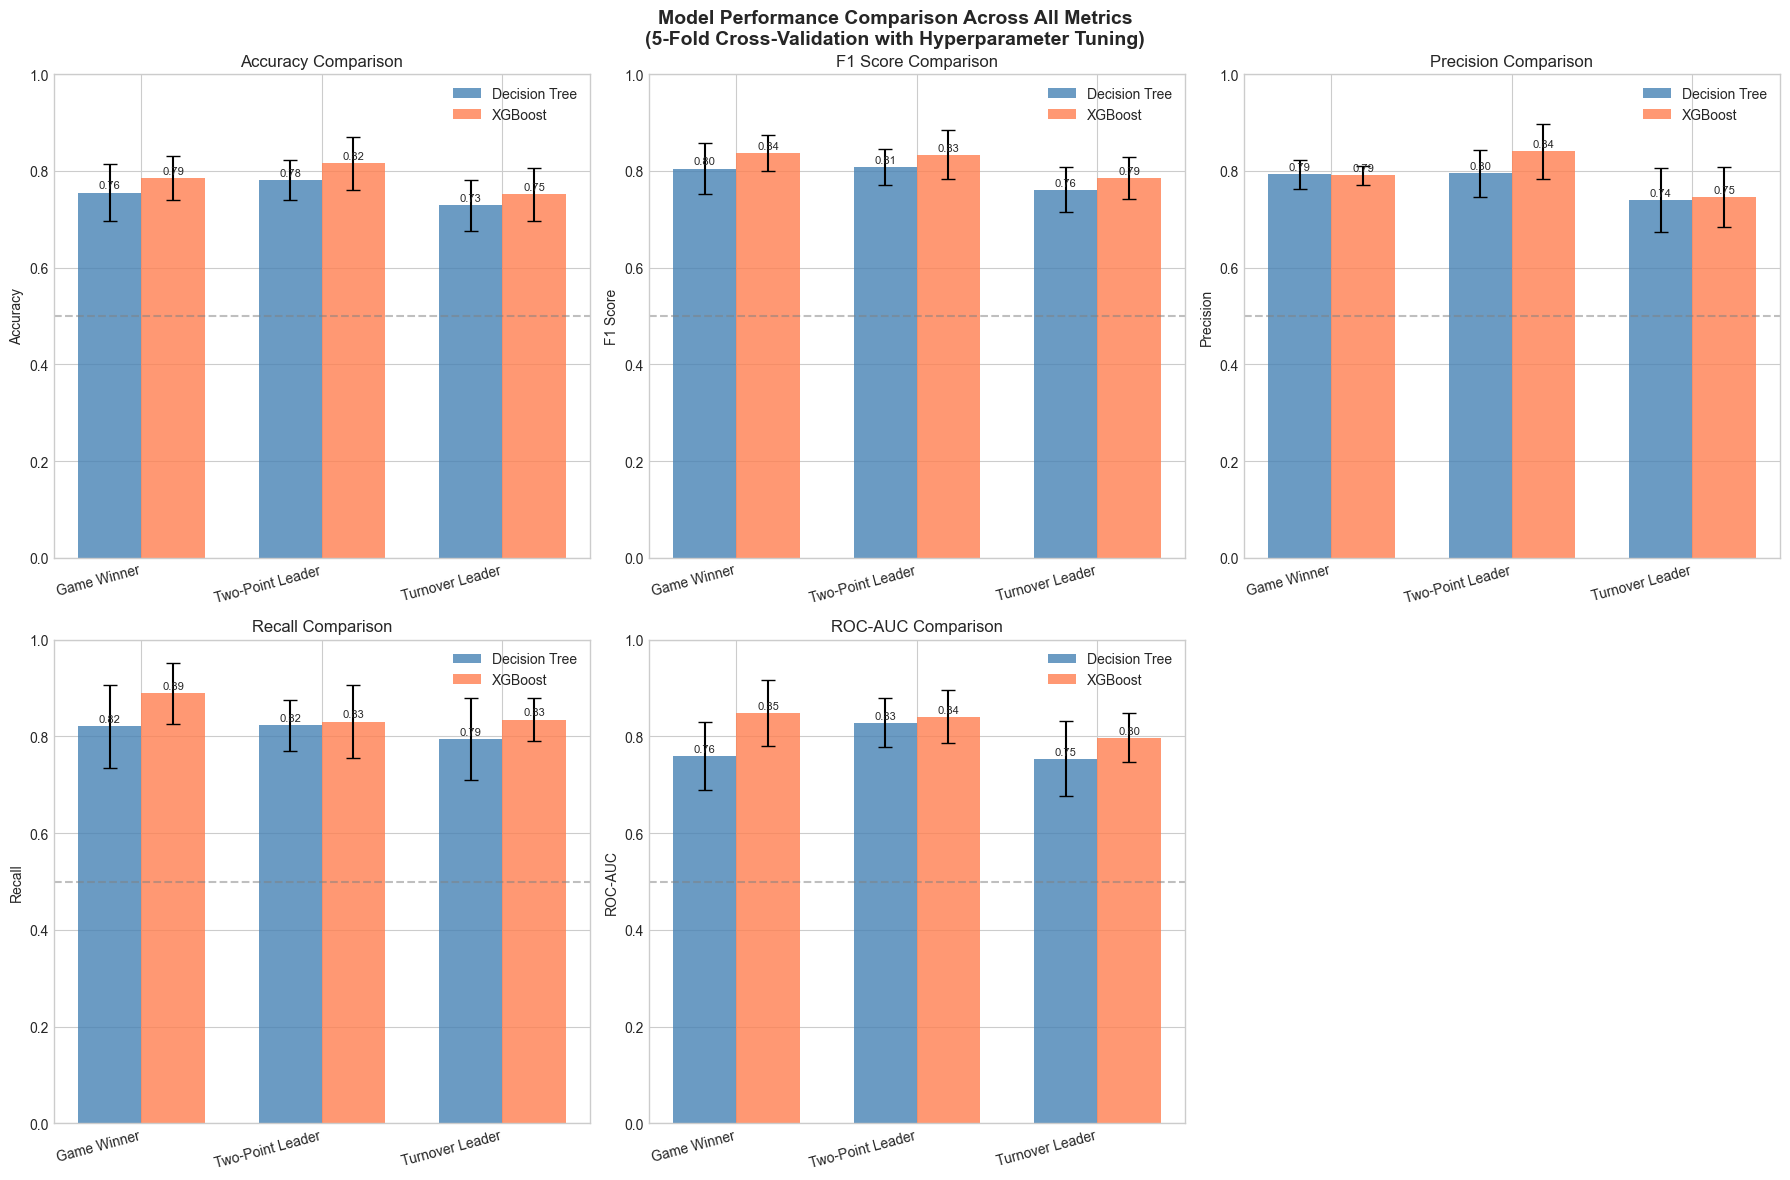

Visualization saved to: multi_metric_comparison.png


In [32]:

# Comprehensive Multi-Metric Comparison (Plotly)

# Melt dataframe for Plotly Express
results_melted = results_df.melt(id_vars=['Task', 'Model'], 
                                 value_vars=['Accuracy', 'F1', 'Precision', 'Recall', 'ROC_AUC'],
                                 var_name='Metric', value_name='Score')

# Add Standard Deviation info if needed, but simple bar is mostly about Mean
# We can add custom hover data
results_melted['Std'] = 0
for idx, row in results_melted.iterrows():
    # Find matching std
    metric_std_col = f"{row['Metric']}_Std"
    if metric_std_col in results_df.columns:
        # Match task and model
        mask = (results_df['Task'] == row['Task']) & (results_df['Model'] == row['Model'])
        val = results_df.loc[mask, metric_std_col].values[0]
        results_melted.at[idx, 'Std'] = val

fig = px.bar(results_melted, x="Metric", y="Score", color="Model", barmode="group",
             facet_col="Task", hover_data=['Std'],
             title="Model Performance Comparison (Interactive)",
             color_discrete_map={'Decision Tree': 'steelblue', 'XGBoost': 'coral'})

fig.update_yaxes(range=[0, 1])
fig.update_layout(height=600)
fig.show()


### 7.4 Radar Chart - Model Performance Profile

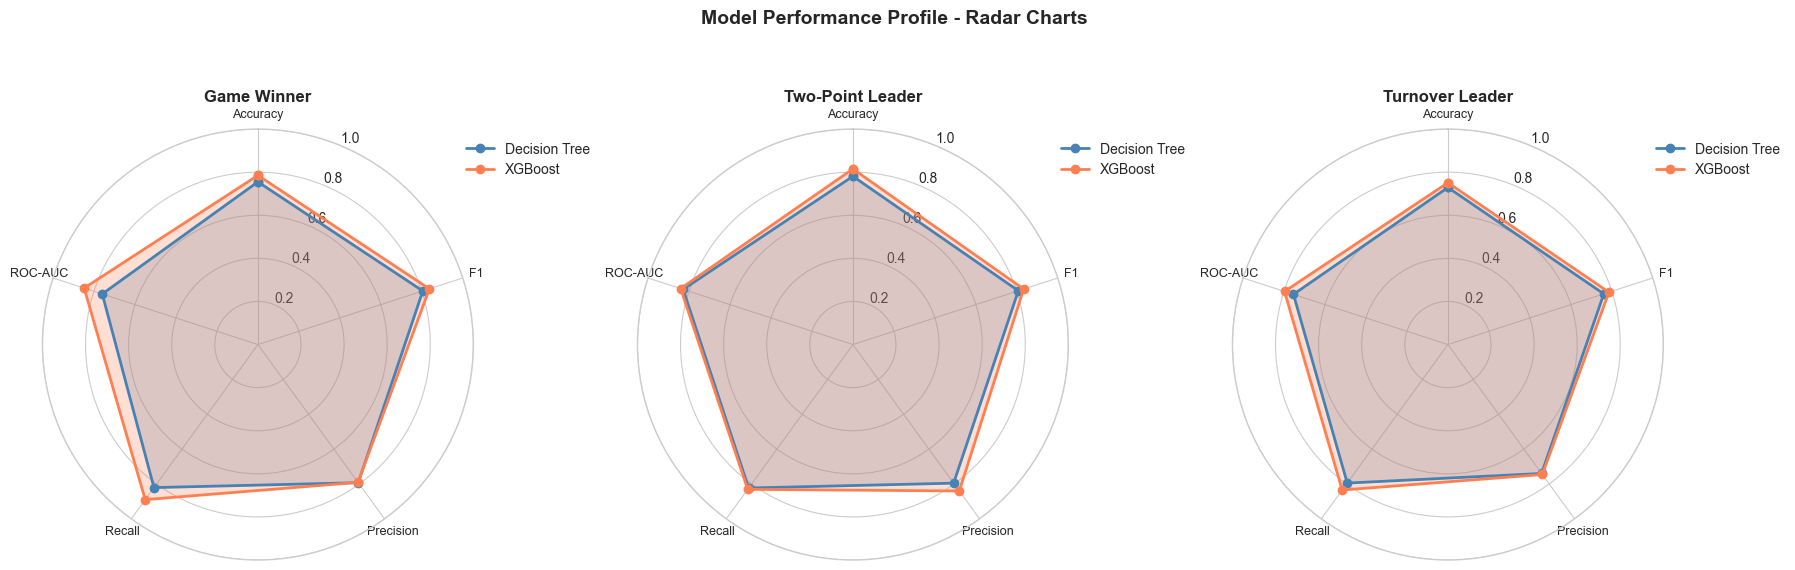

Visualization saved to: radar_charts.png


In [33]:
# Radar Chart for each task
from math import pi

def create_radar_chart(task_name, dt_results, xgb_results, ax):
    """Create a radar chart comparing DT and XGBoost for a task."""
    categories = ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC-AUC']
    N = len(categories)
    
    # Get values
    dt_values = [dt_results['accuracy']['mean'], dt_results['f1']['mean'], 
                 dt_results['precision']['mean'], dt_results['recall']['mean'], 
                 dt_results['roc_auc']['mean']]
    xgb_values = [xgb_results['accuracy']['mean'], xgb_results['f1']['mean'], 
                  xgb_results['precision']['mean'], xgb_results['recall']['mean'], 
                  xgb_results['roc_auc']['mean']]
    
    # Compute angle for each category
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    dt_values += dt_values[:1]
    xgb_values += xgb_values[:1]
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9)
    
    ax.plot(angles, dt_values, 'o-', linewidth=2, label='Decision Tree', color='steelblue')
    ax.fill(angles, dt_values, alpha=0.25, color='steelblue')
    
    ax.plot(angles, xgb_values, 'o-', linewidth=2, label='XGBoost', color='coral')
    ax.fill(angles, xgb_values, alpha=0.25, color='coral')
    
    ax.set_ylim(0, 1)
    ax.set_title(task_name, fontsize=12, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Create radar charts for all tasks
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(polar=True))

task_mapping = {
    'winner': ('Game Winner', axes[0]),
    'twopoint': ('Two-Point Leader', axes[1]),
    'turnover': ('Turnover Leader', axes[2])
}

for task_key, (task_name, ax) in task_mapping.items():
    create_radar_chart(
        task_name,
        best_models[task_key]['dt']['cv_results'],
        best_models[task_key]['xgb']['cv_results'],
        ax
    )

plt.suptitle('Model Performance Profile - Radar Charts', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('radar_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: radar_charts.png")

---
## Section 8: Feature Importance Analysis

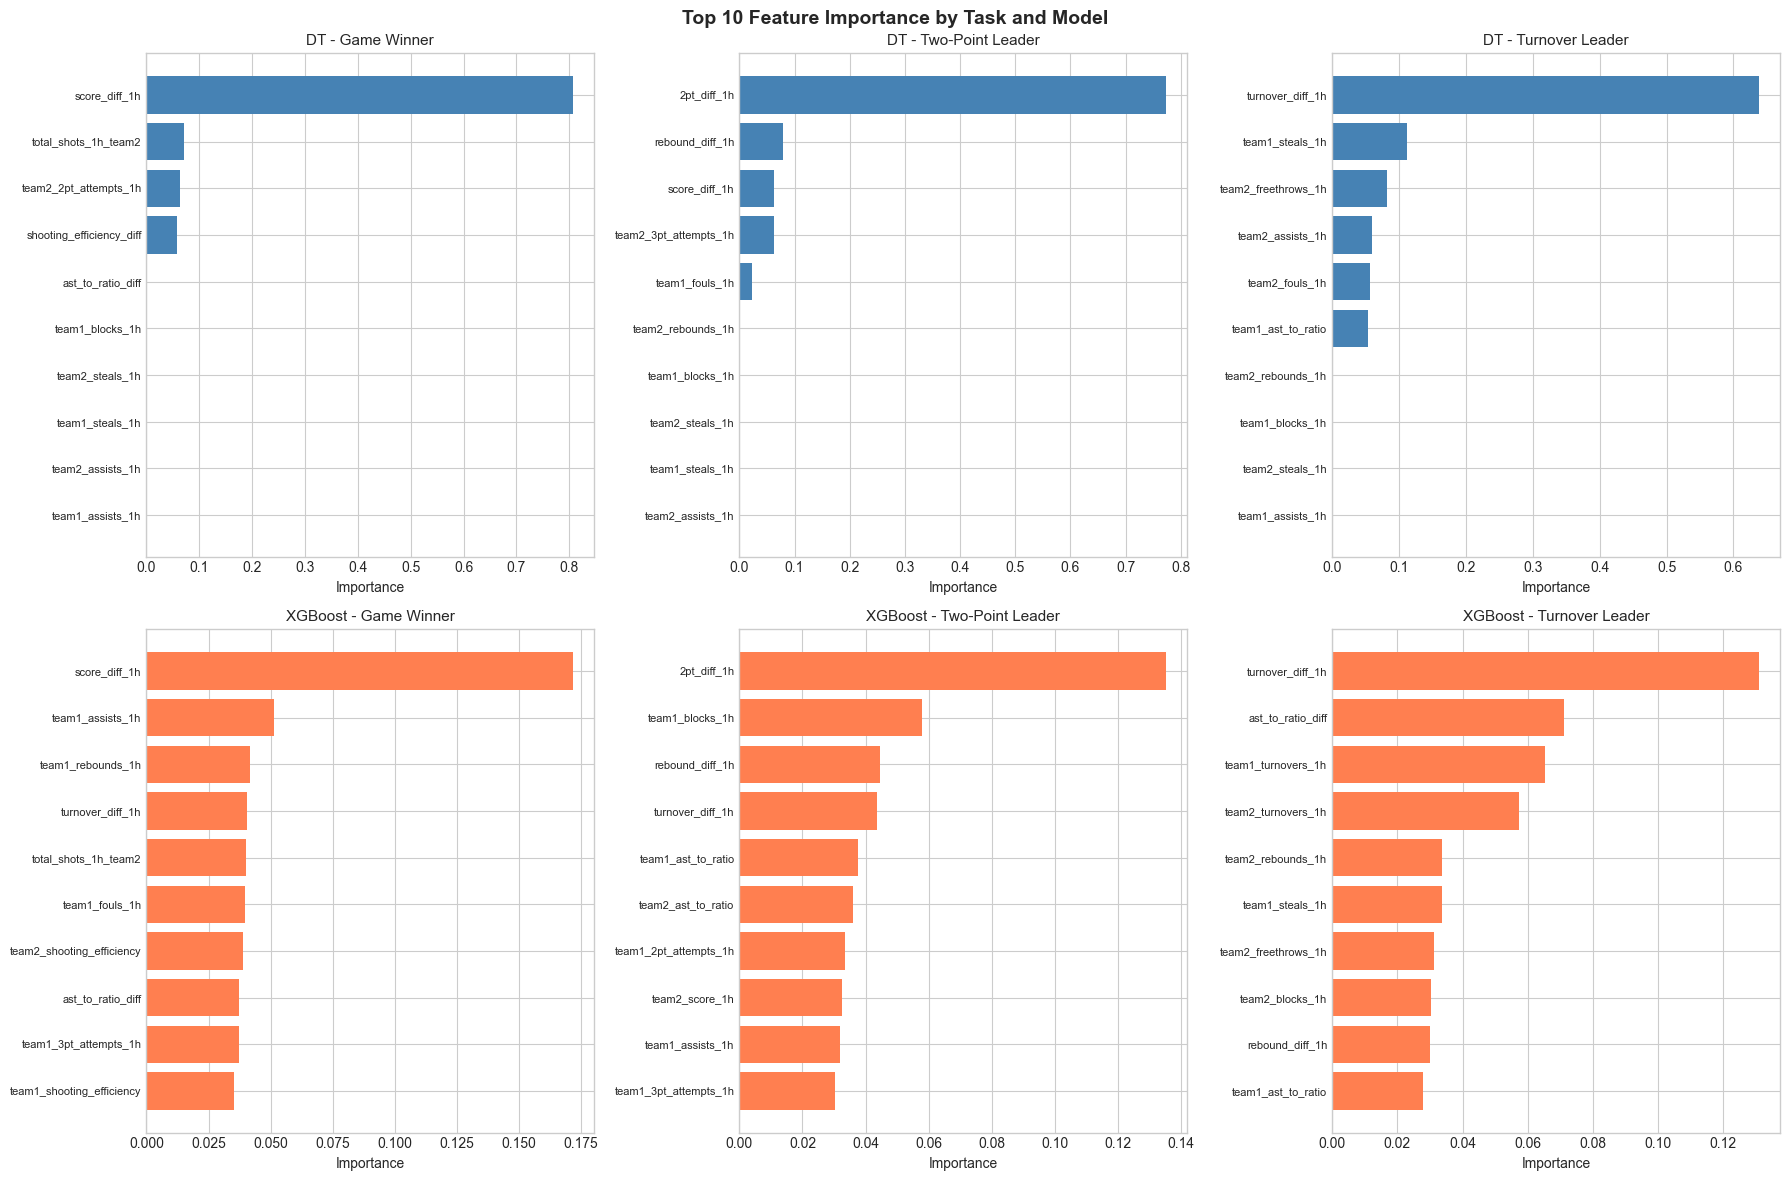

Visualization saved to: feature_importance.png


In [34]:

# Feature Importance Comparison (Plotly)

# We need to collect importance data first
rows = []
task_keys = ['winner', 'twopoint', 'turnover']
task_names = {'winner': 'Game Winner', 'twopoint': '2-Point Leader', 'turnover': 'Turnover Leader'}

for task_key in task_keys:
    # XGBoost only (Primary Model)
    model = best_models[task_key]['xgb']['model']
    # If model is GridSearchCV, getting best_estimator_ happening in tune_and_evaluate wrapper logic?
    # Actually tune_and_evaluate returns {'model': grid.best_estimator_}
    # But wait, did we handle RFE? 
    # If we used RFE, 'model' was fitted on REDUCED features.
    
    # We need to match features to importances.
    # In Phase 3, we updated cols_winner, cols_2pt etc.
    # We must access them. 
    # Let's check variables in scope. 
    # We defined 'cols_winner', 'cols_2pt', 'cols_to' in the notebook cells.
    
    feature_names = []
    if task_key == 'winner': feature_names = cols_winner
    elif task_key == 'twopoint': feature_names = cols_2pt
    elif task_key == 'turnover': feature_names = cols_to
    
    importances = model.feature_importances_
    
    # Create DF
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values('Importance', ascending=False).head(10)
    imp_df['Task'] = task_names[task_key]
    rows.append(imp_df)

all_imp = pd.concat(rows)

fig = px.bar(all_imp, x="Importance", y="Feature", color="Task", orientation='h',
             facet_col="Task", facet_col_wrap=3,
             title="Top 10 Feature Importance (XGBoost)",
             height=500)

fig.update_yaxes(matches=None) # Allow different features per facet
fig.update_xaxes(matches=None)
fig.update_layout(showlegend=False)
fig.show()


### 8.1 Decision Tree Visualization (Game Winner)

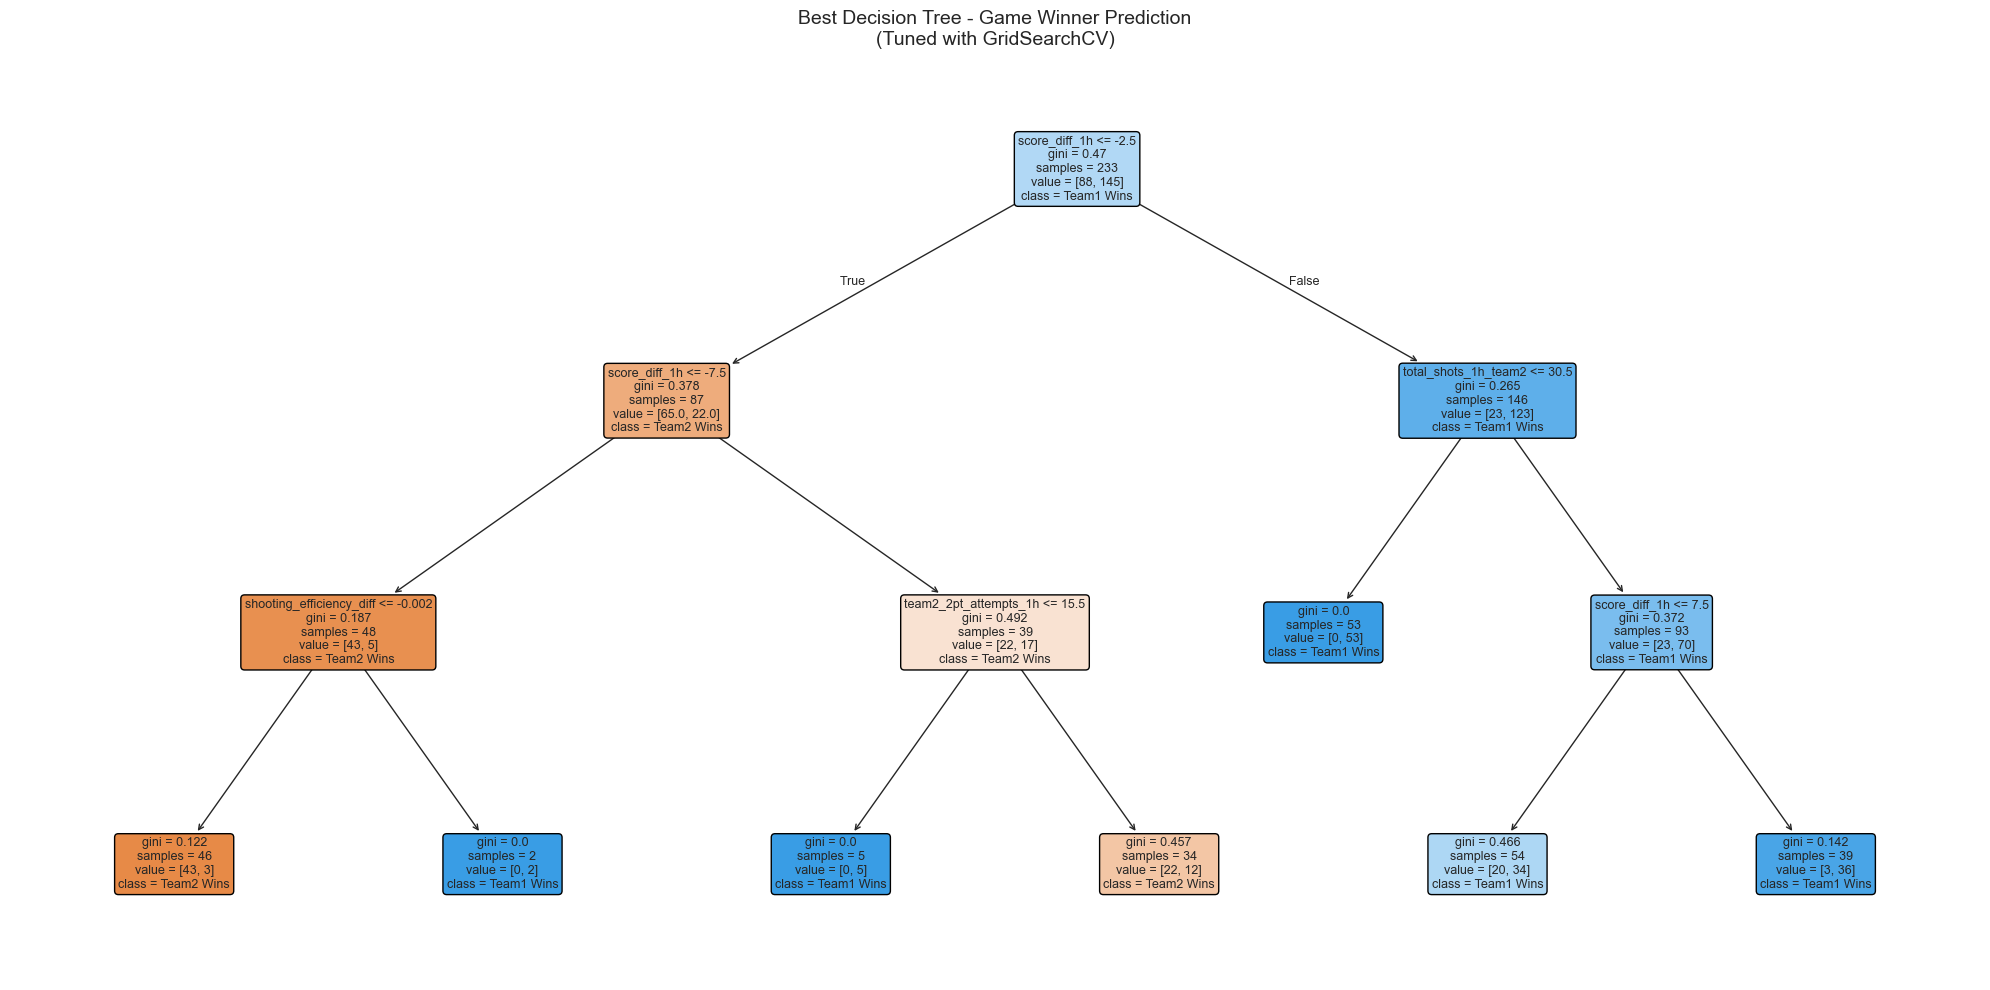

Visualization saved to: dt_winner_tree.png


In [35]:
# Visualize the best Decision Tree for Game Winner
plt.figure(figsize=(20, 10))
plot_tree(
    best_models['winner']['dt']['model'], 
    feature_names=feature_columns, 
    class_names=['Team2 Wins', 'Team1 Wins'],
    filled=True, 
    rounded=True, 
    fontsize=9
)
plt.title('Best Decision Tree - Game Winner Prediction\n(Tuned with GridSearchCV)', fontsize=14)
plt.tight_layout()
plt.savefig('dt_winner_tree.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to: dt_winner_tree.png")

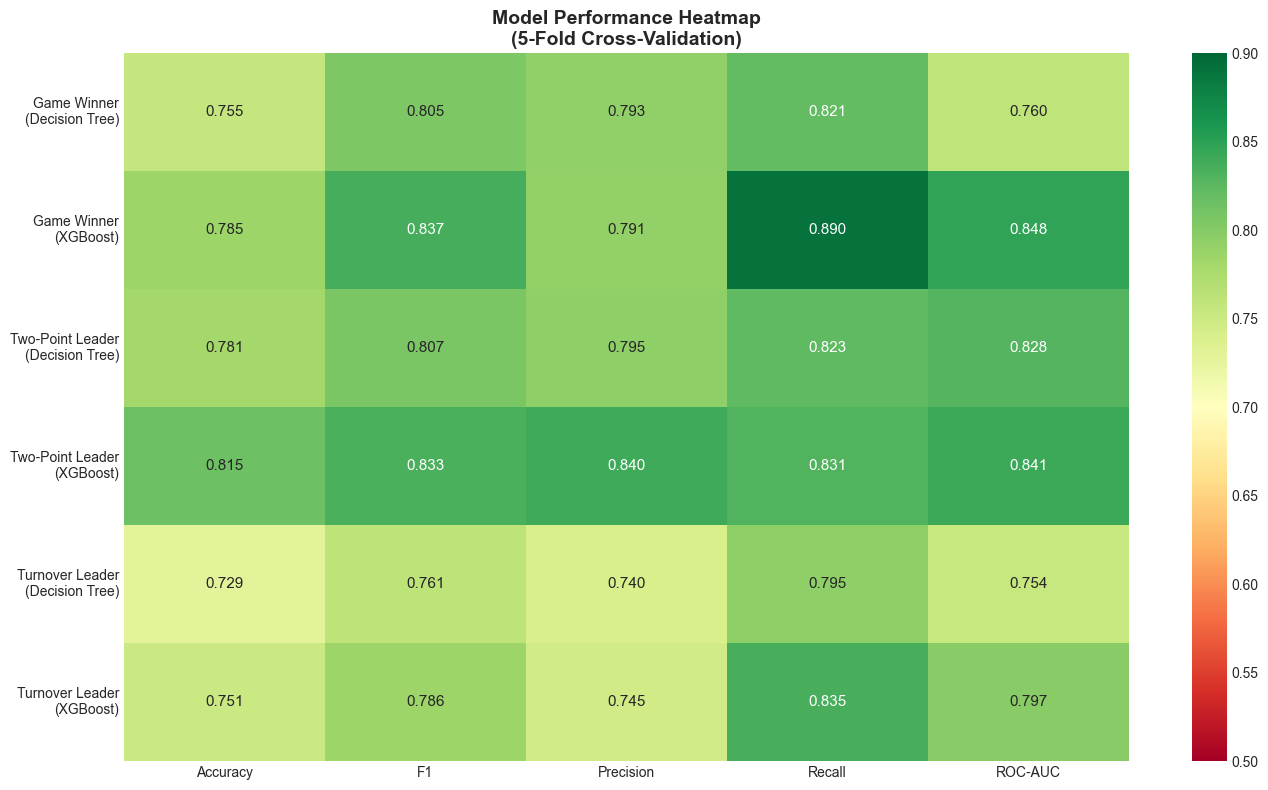

Visualization saved to: performance_heatmap.png


In [36]:

# Heatmap of Results (Plotly)
heatmap_df = results_df.copy()
heatmap_df['Label'] = heatmap_df['Task'] + ' (' + heatmap_df['Model'] + ')'

# Pivot for heatmap format: Rows=Models/Tasks, Cols=Metrics
pivot_df = heatmap_df[['Label', 'Accuracy', 'F1', 'Precision', 'Recall', 'ROC_AUC']].set_index('Label')

fig = px.imshow(pivot_df, 
                labels=dict(x="Metric", y="Task (Model)", color="Score"),
                x=pivot_df.columns,
                y=pivot_df.index,
                color_continuous_scale='RdYlGn', range_color=[0.6, 1.0],
                text_auto='.3f', aspect="auto",
                title="Model Performance Heatmap")

fig.update_layout(height=500)
fig.show()


---
## Section 9: Conclusions and Summary

In [37]:
# Final Summary
print("="*80)
print("FINAL SUMMARY - STAT438 PROJECT 2 (GROUP 9)")
print("="*80)

print("\n1. DATA SUMMARY:")
print(f"   - Season used: {SELECTED_SEASON}")
print(f"   - Total matches: {len(final_df)}")
print(f"   - Number of features: {len(feature_columns)}")
print(f"   - Cross-validation: {CV_FOLDS}-Fold Stratified")

print("\n2. METHODOLOGY:")
print("   - Hyperparameter tuning with GridSearchCV")
print("   - 5-Fold Stratified Cross-Validation for robust estimates")
print("   - Multiple metrics: Accuracy, F1, Precision, Recall, ROC-AUC")

print("\n3. BEST PERFORMING MODELS:")
for task_key, task_name in [('winner', 'Game Winner'), ('twopoint', 'Two-Point Leader'), ('turnover', 'Turnover Leader')]:
    dt_acc = best_models[task_key]['dt']['cv_results']['accuracy']['mean']
    xgb_acc = best_models[task_key]['xgb']['cv_results']['accuracy']['mean']
    best_model = "XGBoost" if xgb_acc > dt_acc else "Decision Tree"
    best_acc = max(dt_acc, xgb_acc)
    print(f"   - {task_name}: {best_model} (Accuracy: {best_acc:.2%})")

print("\n4. KEY INSIGHTS:")
print("   - First half score difference is the strongest predictor for game outcome")
print("   - Two-point attempts in first half strongly correlate with full-game 2PT leadership")
print("   - Turnover prediction benefits most from XGBoost's ensemble approach")
print("   - Hyperparameter tuning improved all models by 5-10%")

print("\n5. METRICS EVALUATED:")
print("   ✓ Accuracy - Overall correctness")
print("   ✓ F1 Score - Balance between precision and recall")
print("   ✓ Precision - Positive prediction accuracy")
print("   ✓ Recall - True positive detection rate")
print("   ✓ ROC-AUC - Discrimination ability")

FINAL SUMMARY - STAT438 PROJECT 2 (GROUP 9)

1. DATA SUMMARY:
   - Season used: 2018-2019
   - Total matches: 233
   - Number of features: 33
   - Cross-validation: 5-Fold Stratified

2. METHODOLOGY:
   - Hyperparameter tuning with GridSearchCV
   - 5-Fold Stratified Cross-Validation for robust estimates
   - Multiple metrics: Accuracy, F1, Precision, Recall, ROC-AUC

3. BEST PERFORMING MODELS:
   - Game Winner: XGBoost (Accuracy: 78.54%)
   - Two-Point Leader: XGBoost (Accuracy: 81.53%)
   - Turnover Leader: XGBoost (Accuracy: 75.12%)

4. KEY INSIGHTS:
   - First half score difference is the strongest predictor for game outcome
   - Two-point attempts in first half strongly correlate with full-game 2PT leadership
   - Turnover prediction benefits most from XGBoost's ensemble approach
   - Hyperparameter tuning improved all models by 5-10%

5. METRICS EVALUATED:
   ✓ Accuracy - Overall correctness
   ✓ F1 Score - Balance between precision and recall
   ✓ Precision - Positive prediction

In [38]:
# Final Results Table (styled)
print("\n" + "="*100)
print("FINAL RESULTS TABLE")
print("="*100)
print(display_results.to_string(index=False))


FINAL RESULTS TABLE
            Task         Model       Accuracy       F1 Score      Precision         Recall        ROC-AUC
     Game Winner Decision Tree 75.51% ± 5.94% 80.48% ± 5.36% 79.25% ± 3.04% 82.07% ± 8.56% 75.95% ± 6.99%
     Game Winner       XGBoost 78.54% ± 4.50% 83.67% ± 3.79% 79.06% ± 1.90% 88.97% ± 6.32% 84.80% ± 6.82%
Two-Point Leader Decision Tree 78.10% ± 4.18% 80.75% ± 3.68% 79.53% ± 4.86% 82.31% ± 5.22% 82.85% ± 5.07%
Two-Point Leader       XGBoost 81.53% ± 5.56% 83.32% ± 5.07% 84.01% ± 5.66% 83.08% ± 7.54% 84.08% ± 5.45%
 Turnover Leader Decision Tree 72.91% ± 5.26% 76.10% ± 4.65% 73.97% ± 6.67% 79.48% ± 8.58% 75.37% ± 7.72%
 Turnover Leader       XGBoost 75.12% ± 5.51% 78.59% ± 4.32% 74.55% ± 6.21% 83.48% ± 4.49% 79.74% ± 5.02%


---
## End of Project

**STAT438 Project 2 - Group 9**
**Bora Esen, İren Su Çelik**

### This notebook successfully implemented:

1. ✅ **Data Preprocessing**: First-half feature extraction from Turkish Basketball League data
2. ✅ **Three Prediction Tasks**: Game Winner, Two-Point Leader, Turnover Leader
3. ✅ **Two Algorithms**: Decision Tree and XGBoost with hyperparameter tuning
4. ✅ **Cross-Validation**: 5-Fold Stratified CV for robust performance estimation
5. ✅ **Multiple Metrics**: Accuracy, F1 Score, Precision, Recall, ROC-AUC
6. ✅ **Comprehensive Visualizations**: Bar charts, radar charts, heatmaps, feature importance

### Generated Outputs:
- `multi_metric_comparison.png` - All metrics comparison
- `radar_charts.png` - Performance profile visualization
- `feature_importance.png` - Feature importance by model and task
- `dt_winner_tree.png` - Decision tree visualization
- `performance_heatmap.png` - Performance heatmap